In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.autograd as ag
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision import models

import ASDC_loader
import ModelUtil


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device = torch.device('cpu')

def save_whole_checkpoint():
    ASDC_loader.save_checkpoint(param_path, 
                                model=model, 
                                optimizer=optimizer, 
                                epoch=epoch, 
                                idx=idx, 
                                B=B, 
                                losses=losses, 
                                train_accs=train_accs,
                                val_accs=val_accs)   
def bilinear_kernel(size):
    factor = math.floor((size+1)/2)
    if size % 2 == 1:
            center = factor - 1
    else:
            center = factor - 0.5
    grid = [ torch.linspace(0,size-1,size).view(size,1),
                           torch.linspace(0,size-1,size).view(1,size) ]
    kernel = (1 - torch.abs(grid[0]-center)/factor).matmul((1 - torch.abs(grid[1]-center)/factor))
    return kernel

cuda


In [2]:
crop_size = (128,128)
truncate_len = 192555
truncate_len = 160000
truncate_len = 40000
train_range, val_range = ModelUtil.make_val_ranges(truncate_len, 4, 0)

train_class_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='train', ID_idxs=train_range, truncate=truncate_len, crop=crop_size)
val_class_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='validate', ID_idxs=val_range, truncate=truncate_len, crop=crop_size)
print('train:\t' + str(len(train_range)) +' images,\t'+ str(len(train_class_dataset))+ ' samples')
print('vali:\t' + str(len(val_range)) + ' images,\t'+ str(len(val_class_dataset))+ ' samples')

train:	30000 images,	35790 samples
vali:	10000 images,	12141 samples


In [3]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        
        self.if_class = True
        self.common_modules()
        self.fcn_modules()
        self.init_params()
        
        
    def common_modules(self):
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional Layer 3
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
         
            # End of Conv 3
        )
        
        self.conv_4 = nn.Sequential(
            # Convolutional Layer 4
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #End of Convolutional Layer 4
        )
        self.conv_5 = nn.Sequential(
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Image size is now 8x8, depth 512
            
        )
        
        self.fc6 = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, stride=1,padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5,inplace=False),
            # 8x8, 4096
        )
        
        self.fc7 = nn.Sequential(
            nn.Conv2d(4096, 4096, kernel_size=1, stride=1,padding=0),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5,inplace=False)
            # 8x8 image, depth 4096
        )
        
        self.full_resolution = nn.Sequential(
            #Full Resolution
            # 8x8 image, depth 4096 input
            nn.Conv2d(4096,2,kernel_size=1, stride=1, padding=0)
            # 8x8 image, depth 2 output
            
        )
        
        self.small_classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4*4*512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
#             nn.Linear(8*8*2, 2),
        )
        
    def fcn_modules(self):
        self.deconv_2 = nn.Sequential(
            nn.ConvTranspose2d(2,2,kernel_size=4, stride=2,bias=False)
        )
        
        self.score_pool_4 = nn.Sequential(
            nn.Conv2d(512,2,kernel_size=1,padding=0)
            
            # Note: Left out n.score_pool4c from https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/voc-fcn8s/net.py
        )
        
        self.upscore_pool_4 = nn.Sequential(
            nn.ConvTranspose2d(2,2,kernel_size=4,stride=2,bias=False)
 
        )
        
        self.score_pool_3 = nn.Sequential(
            nn.Conv2d(256,2,kernel_size=1,padding=0)
            #Crop excluded again
            
        )
        
        self.upscore_8 = nn.Sequential(
            nn.ConvTranspose2d(2,2,kernel_size=16,stride=8,bias=False,padding=4)
        )
        
        self.classifier = nn.Sequential(
            nn.Softmax()
        )
        
    def init_params(self):
        #Initilize the paremeters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        self.init_fcn_modules()
    
    def init_fcn_modules(self):
        modules = [self.fc6,
                self.fc7,
                self.full_resolution,
                self.score_pool_4,
                self.score_pool_3]
        for module in modules:
            for m in module.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         self.init_deconv()

    def init_deconv(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                s = m.weight.shape
                kernel = bilinear_kernel(s[-1])
                for i in range(s[0]):
                    for j in range(s[1]):
                        m.weight.data[i,j,:,:] = kernel
    
    def forward(self, x):
        if not self.if_class:
            x_after_conv_4 = self.conv_4(self.features(x)) # 16x16 expected, giving 23x23
            x_fr = self.fc7(self.fc6(self.conv_5(x_after_conv_4)))
            x_fr = self.full_resolution(x_fr)
            x_fr_deconv = self.deconv_2(x_fr) #16 x 16
            x_fr_deconv = x_fr_deconv.narrow(2,1,16).narrow(3,1,16)
#             print(x_after_conv_4.shape)
#             print(x_fr_deconv.shape)
            x_fused_4_fr = torch.add(x_fr_deconv, self.score_pool_4(x_after_conv_4))
    
            x_fused_4_fr = self.upscore_pool_4(x_fused_4_fr)
            x_score_pool_3 = self.score_pool_3(self.features(x))
            x_fused_4_fr = x_fused_4_fr.narrow(2,1,32).narrow(3,1,32)
#             print(x_fused_4_fr.shape)
            x_fused_3_4_fr = self.upscore_8(torch.add(x_fused_4_fr, x_score_pool_3))
#             print(x_fused_3_4_fr.shape)
            # x = x.view(x.size(0), 256 * 7 * 7)
            output = self.classifier(x_fused_3_4_fr)           
#             output = F.softmax(output, dim=1)

#             x_fused_4_fr = torch.add(self.deconv_2(self.full_resolution(self.after_conv_4(self.conv_4(self.features(x))))), self.score_pool_4(self.conv_4(self.features(x))))
            

            # x = x.view(x.size(0), 256 * 7 * 7)
#             output = torch.nn.softmax(torch.add(x_fused_4_fr, self.score_pool_3(self.features(x))))
            
        else: 
            return self.class_small_forward(x)
        return output
    
    def class_small_forward(self, x):
#         x = self.features(x)
#         x = self.conv_4(x)
#         x = self.conv_5(x)
#         x = self.fc6(x)
#         x = self.fc7(x)
#         x = self.full_resolution(x)
#         x = x.view(x.shape[0],2*8*8)
#         x = self.small_classifier(x)
        x = self.features(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
#         x = self.fc6(x)
#         x = self.fc7(x)
        x = x.view(x.shape[0],512*4*4)
        x = self.small_classifier(x)
        return x
        
    
    def set_classify(self):
        self.if_class = True
    def set_fcn(self):
        self.if_class = False

In [4]:
# param_path = 'alex_net_params_11.pt'

# alex_model = AlexNetModel.AlexNet(2)

# checkpoint_dict = ModelUtil.load_checkpoint(param_path)

# alex_model.load_state_dict(checkpoint_dict['model_state_dict'])
# # alex_model.load_state_dict(torch.load('alexparams.pth'))
# alex_model.remove_classifier()

model = VGGNet(num_classes=2).to(device)


# fcn_model = FCN8s(pretrained_net=alex_model, n_class=2).to(device)

# Classifier training

In [5]:
B = 16 # Minibacth size
T = 3 # Number of epochs
gamma = .005 # learning rate
rho = .9 # momentum
scheduler_period = 500 #units of batches
validate = False

# Data loader (this provides queues and threads in a very simple way).
train_class_loader = torch.utils.data.DataLoader(dataset=train_class_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                           num_workers=8)
val_class_loader = torch.utils.data.DataLoader(dataset=val_class_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                           num_workers=8)

#test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=B)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

print('done')

done


In [6]:
param_path = './vgg_class.pt'

if not os.path.isfile(param_path):
    ModelUtil.save_checkpoint(param_path, model=model, optimizer=optimizer)
    print('using new model')
else:
    print('using local model')

checkpoint_dict = ModelUtil.load_checkpoint(param_path, model=model, optimizer=optimizer)
#print(checkpoint_dict)
# if 'B' in checkpoint_dict:
#     assert B == checkpoint_dict['B'], 'current minibatch size is %d, but saved size is %d' % (B, checkpoint_dict['B'])


using local model


In [7]:
#classifier training
model.train()

last_time = time.time()
print('start time: %f' % time.time())

losses = [] if 'losses' not in checkpoint_dict else checkpoint_dict['losses']
train_accs = [] if 'train_accs' not in checkpoint_dict else checkpoint_dict['train_accs']
val_accs = [] if 'val_accs' not in checkpoint_dict else checkpoint_dict['val_accs']
best_val = 0

epoch = 0
while epoch < T:
    if 'epoch' in checkpoint_dict and epoch <= checkpoint_dict['epoch']:
        epoch += 1
        continue
    running_loss = 0.0
    scheduler_running_loss = 0.0
    num_correct = 0.0
    num_total = 0.0
    epoch_time = time.time()
    
    for idx, (images, labels) in enumerate(train_class_loader):        
        images = images.to(device)
        

        # Forward pass
        outputs = model(images)
        
        pred_labels = ModelUtil.onehot2label(outputs).cpu()
        num_correct += torch.sum(labels.cpu()==pred_labels)
        num_total += labels.shape[0]
        
        labels = labels.to(device)
        # loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print averaged loss per minibatch every 100 mini-batches
        running_loss += loss.item() 
        if idx % 100 == 99:
            print('[%d, %5d] loss: %.3f accu: %.3f' % 
                  (epoch + 1, idx + 1, running_loss/100, float(num_correct)/float(num_total)))
            losses.append((epoch, idx, running_loss/100))
            scheduler_running_loss += running_loss
            running_loss = 0.0 
            if idx <= 500:
                print('sec per sample: {:f}'.format((time.time()-last_time)/(B*100)))#time_per_sample = (last_time-time.time())/(B*100)
                last_time = time.time()
        
        if idx % scheduler_period == scheduler_period-1:
            print('scheduler running loss: {:.5f}'.format(scheduler_running_loss/scheduler_period))
            scheduler.step(scheduler_running_loss/scheduler_period)
            scheduler_running_loss = 0.0

    
        # Release RAM
        #torch.cuda.empty_cache()    
    last_time = time.time()
    print('[{:03d} {:05d}] epoch took {:02f} secs to run'.format(epoch+1, idx+1, time.time()-epoch_time))
    
    if validate:
        #evaluate training accuracy
#         tmp_time = time.time()
#         train_acc = ModelUtil.eval_class_dataset(model, train_loader, device)
#         print('[{:03d} {:05d}] {:02f} secs to run \t training accuracy: {:04f}'.format(epoch+1, 
#                                                                                        idx+1, 
#                                                                                        time.time()-tmp_time, 
#                                                                                        train_acc))
#         train_accs.append((epoch, idx, train_acc))

        #evaluate validation accuracy
        tmp_time = time.time()
        val_acc = ModelUtil.eval_class_dataset(model, val_class_loader, device)
        print('[{:03d} {:05d}] {:02f} secs to run \t validati accuracy: {:04f}'.format(epoch+1, 
                                                                                       idx+1, 
                                                                                       time.time()-tmp_time, 
                                                                                       val_acc))
        val_accs.append((epoch, idx, val_acc))
        if val_acc > best_val:
            ModelUtil.save_checkpoint('vgg_class_best.pt', model=model)
            best_val = val_acc
            
    #done with one epoch
    save_whole_checkpoint()           
    print('saved at {:f}'.format(time.time()))
    
    epoch += 1
    
print('Finished Training')

start time: 1544797743.177963
Finished Training


In [8]:
ModelUtil.load_checkpoint('vgg_class_best.pt', model=model)
# ModelUtil.eval_class_dataset(model, val_class_loader, device)

no optimizer in checkpoint file


{'model_state_dict': OrderedDict([('features.0.weight',
               tensor([[[[ 0.0072, -0.0217,  0.0441],
                         [-0.0477, -0.0434, -0.0707],
                         [-0.0603, -0.0840, -0.1102]],
               
                        [[ 0.0410,  0.0025, -0.0333],
                         [ 0.0187,  0.0114, -0.0353],
                         [-0.1053,  0.0260, -0.0052]],
               
                        [[-0.0464,  0.0524,  0.0576],
                         [-0.0188, -0.0695,  0.0476],
                         [ 0.0013, -0.0710, -0.0440]]],
               
               
                       [[[-0.0394,  0.0740, -0.0048],
                         [ 0.0444, -0.0500, -0.0583],
                         [-0.0837, -0.0336,  0.0050]],
               
                        [[ 0.0239,  0.0119,  0.0138],
                         [-0.0658,  0.0584, -0.0343],
                         [ 0.0183, -0.0338,  0.0519]],
               
                        [[-0.202

In [9]:
torch.cuda.empty_cache()

In [10]:
model.set_fcn()

In [11]:
B = 8  # Minibatch size
T = 3 # Number of epochs
gamma = 10e-3 # learning rate
rho = .9 # momentum
loss_set = [float('inf')]

bkpoint = 0 #break point of the training

criterion = nn.BCEWithLogitsLoss().to(device)
# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.1, 10.0])).to(device)
# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([10.0, 0.01])).to(device)

# TO DO: Set learning rate to 0 for the two crucial layers

# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho)
optimizer = torch.optim.SGD([{'params': model.deconv_2.parameters(), 'lr': 0},
                            {'params': model.upscore_pool_4.parameters(), 'lr': 0},
                            {'params': model.upscore_8.parameters(), 'lr': 0}], lr=gamma, momentum=rho)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

In [12]:
fcn_param_path = './vgg_fcn.pt'

fcn_keys = ['fc6.0.weight',
    'fc6.0.bias',
    'fc7.0.weight',
    'fc7.0.bias',
    'full_resolution.0.weight',
    'full_resolution.0.bias',
    'deconv_2.0.weight',
    'score_pool_4.0.weight',
    'score_pool_4.0.bias',
    'upscore_pool_4.0.weight',
    'score_pool_3.0.weight',
    'score_pool_3.0.bias',
    'upscore_8.0.weight']

if not os.path.isfile(fcn_param_path):
    model.init_fcn_modules()
    ModelUtil.save_checkpoint(fcn_param_path, model=model, optimizer=optimizer)
    print('using new model')
else:
    red_checkpoint_dict = ModelUtil.load_checkpoint(fcn_param_path)
    #update fcn parameters only !!!!!
    model_state = model.state_dict()
    for key in fcn_keys:
        model_state[key] = red_checkpoint_dict['model_state_dict'][key]
    model.load_state_dict(model_state)
    print('using local model')
    ModelUtil.save_checkpoint(fcn_param_path, model=model, optimizer=optimizer)

checkpoint_dict = ModelUtil.load_checkpoint(param_path)

using local model


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type VGGNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
# Data set
train_dataset = ASDC_loader.ASDC_Crop_Mask2_Dataset(dataset='train', ID_idxs=train_range, truncate=-1, crop=(256,256))
val_dataset = ASDC_loader.ASDC_Crop_Mask2_Dataset(dataset='train', ID_idxs=val_range, truncate=-1, crop=(256,256))

# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=B,
                                           num_workers=8,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=B,
                                           num_workers=8,
                                           shuffle=True)

In [14]:
print("Training from epoch {}".format(bkpoint))
print("Batchsize: ", B)
print("Num_epohs: ", T)
print("Learn_rate: ", gamma)
print("============================")
# print("Break point: epoch: {}, idx: {}".format(epoch, idx))

for epoch in range(bkpoint, T):
    running_loss = 0.0
    for idx, (images, labels) in enumerate(train_loader):
        
#         images = ag.Variable(images.to(device), requires_grad=True)
#         labels = ag.Variable(labels.to(device), requires_grad=False)
        images = images.to(device)
#         labels = labels[:,0,:,:].type(torch.LongTensor)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        outputs = outputs.float()
        
        
        # Loss
        loss = criterion(outputs, labels)
        
        #saving the loss
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Print averaged loss per minibatch every 30 mini-batches
        running_loss += loss.item() 
        if idx % 100 == 99:
            print('[%d, %5d] loss: %.5f' % 
                  (epoch + 1, idx + 1, running_loss/100))
            
            scheduler.step(running_loss/100)
            if running_loss/100 <= min(loss_set):
                ModelUtil.save_checkpoint('vgg_fcn_best.pt', model=model, optimizer=optimizer)            
                print("=====Best Model is saved at epoch: {}, idx: {}, loss: {}======".format(epoch+1, idx+1, loss.detach().cpu()))
                loss_set.append(running_loss/100)
    #             torch.save(model.state_dict(), 'params_best.pth')
    #             np.savetxt('loss_best.txt',loss_set,fmt='%0.8f')
            running_loss = 0.0 
            
        
        # Saving the model
        if (idx+1) % 1000 ==999:
            ModelUtil.save_checkpoint(fcn_param_path, model=model, optimizer=optimizer)            
            print("=====Model is saved at epoch: {}, idx: {}======".format(epoch+1, idx+1))
#             torch.save(model.state_dict(), 'params.pth')
#             np.savetxt('loss.txt',loss_set,fmt='%0.8f')
        
        
        

        # Release RAM
        torch.cuda.empty_cache()

print('Finished Training')

Training from epoch 0
Batchsize:  8
Num_epohs:  3
Learn_rate:  0.01


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[1,   100] loss: 0.55809


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type VGGNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


=====Best Model is saved at epoch: 1, idx: 100, loss: 0.5133188366889954======
[1,   200] loss: 0.50992
=====Best Model is saved at epoch: 1, idx: 200, loss: 0.507571280002594======
[1,   300] loss: 0.50899
=====Best Model is saved at epoch: 1, idx: 300, loss: 0.5054646134376526======
[1,   400] loss: 0.50828
=====Best Model is saved at epoch: 1, idx: 400, loss: 0.5059197545051575======
[1,   500] loss: 0.50869
[1,   600] loss: 0.50925
[1,   700] loss: 0.50855
[1,   800] loss: 0.50847


Process Process-3:
Process Process-4:
Process Process-8:
Process Process-1:
Process Process-7:
Process Process-6:
Process Process-5:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/li

  File "/opt/conda/lib/python3.6/site-packages/PIL/Image.py", line 1220, in getdata
    self.load()
  File "/opt/conda/lib/python3.6/site-packages/PIL/ImageFile.py", line 231, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [15]:
val_iter = iter(val_loader)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


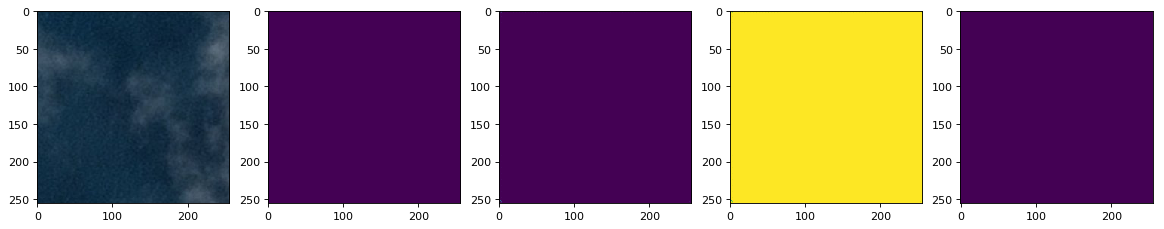

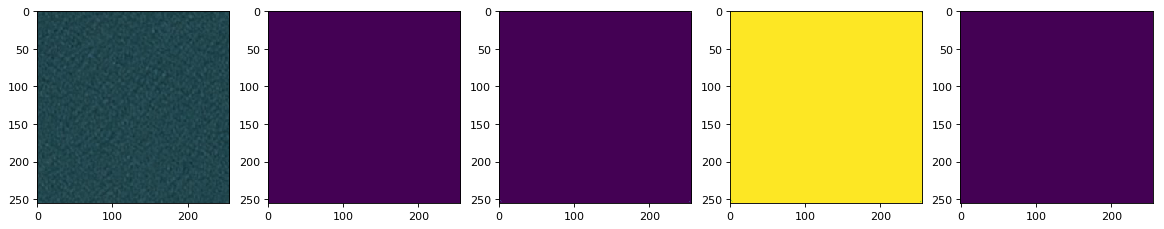

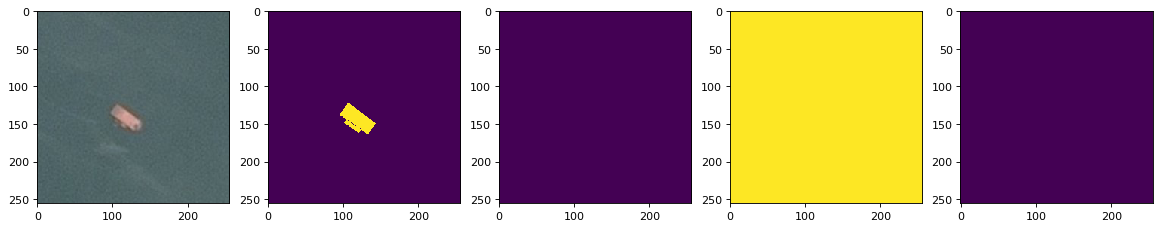

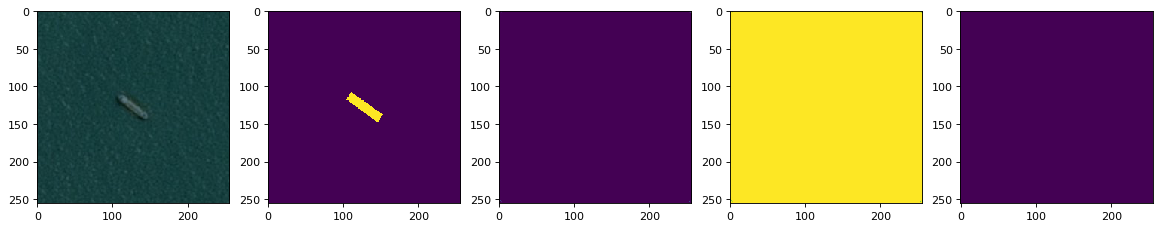

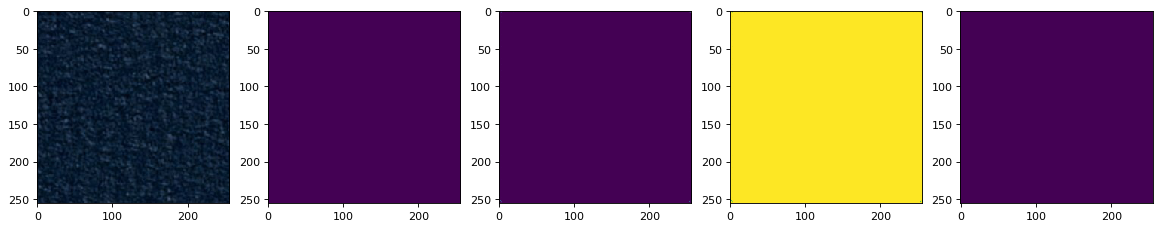

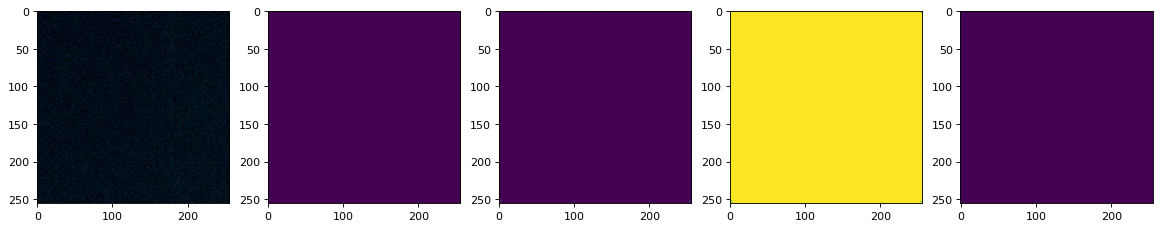

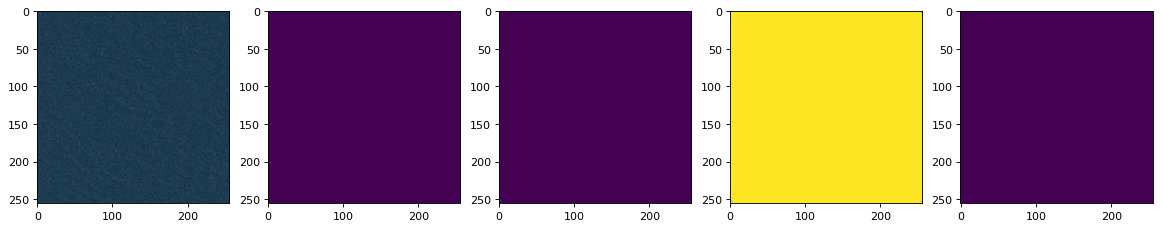

In [16]:
images, masks = next(val_iter)
preds = model(images.to(device))
preds = preds.detach().cpu()
for x in range(len(images)):
    image = images[x,:,:,:]
    mask = masks[x,:,:,:]
    pred = preds[x,:,:,:]
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(1,5,1)
    plt.imshow(ASDC_loader.torch2regular_image(image))
    plt.subplot(1,5,2)
    plt.imshow(mask[0,:,:])
    plt.subplot(1,5,3)
    plt.imshow(pred[0,:,:])
    plt.subplot(1,5,4)
    plt.imshow(pred[1,:,:])
    plt.subplot(1,5,5)
    plt.imshow(pred[1,:,:] < pred[0,:,:])

In [ ]:
np.mean(pred.numpy()[0,:,:])
np.mean(pred.numpy()[1,:,:])

In [ ]:
plt.figure()
plt.imshow(labels[2,:,:])
plt.figure()
plt.imshow(outputs.detach().cpu().numpy()[2,0,:,:])
plt.figure()
plt.imshow(outputs.detach().cpu().numpy()[2,1,:,:])

In [ ]:
size = 4
factor = math.floor((size+1)/2)
if size % 2 == 1:
        center = factor - 1
else:
        center = factor - 0.5
grid = [ torch.linspace(0,size-1,size).view(size,1),
                       torch.linspace(0,size-1,size).view(1,size) ]


In [ ]:
grid

In [ ]:
(1 - torch.abs(grid[0]-center)/factor).matmul((1 - torch.abs(grid[1]-center)/factor))

In [ ]:
for m in model.modules():
    if isinstance(m, nn.ConvTranspose2d):
        s = m.weight.shape
        kernel = bilinear_kernel(s[-1])
        for i in range(s[0]):
            for j in range(s[1]):
                m.weight[i,j,:,:] = kernel
        print(m.weight.shape)


In [ ]:
for m in model.modules():
    if isinstance(m, nn.ConvTranspose2d):
        print(m.weight)
        print(m.bias)


In [ ]:
for x in model.fc6.modules():
    if isinstance(x,nn.Conv2d):
        print(x)


In [ ]:
print(model.deconv_2[0].weight)
